In [1]:
from array import array
import math
import numpy as np
from scipy.fftpack import fft
import random

In [2]:
fs = 0.2
phis = 0.0
N = 50
tseries = 10.0

random.seed(1)

In [3]:
tau = tseries/N
t = np.zeros(N)
y = np.zeros(N)
f = np.zeros(N)

yhigh = np.zeros(1000)
ylow = np.zeros(1000)
time = np.zeros(1000)

ytReal = np.zeros(N)
ytImag = np.zeros(N)

yfftReal = np.zeros(N)
yfftImag = np.zeros(N)

power = np.zeros(N)
powerfft = np.zeros(N)

In [4]:
for i in range(N):
    t[i]=i*tau
    y[i]=(1.0+0.2*random.uniform(0,1))*math.sin(2.0*math.pi*t[i]*fs+phis)
    f[i]=i/(N*tau)

In [5]:
from timeit import default_timer as timer

start = timer()

twopiN=-2.0*math.pi/N
epsilon = 0.001
for k in range(N):
    ytReal[k]=epsilon
    ytImag[k]=epsilon
    for j in range(N):
        ytReal[k] = ytReal[k] + 1.0/N*y[j]*math.cos(twopiN*j*k)
        ytImag[k] = ytImag[k] + 1.0/N*y[j]*math.sin(twopiN*j*k)   
    power[k]=2*(ytReal[k]**2+ytImag[k]**2)
    
end = timer()
btime = end-start
print ("Brash: ",btime)
ymaxr = max(ytReal)
ymaxi = max(ytImag)
ymax = 1.2*max(ymaxr,ymaxi)

Brash:  0.005027161000000002


In [6]:
integral = 0.0
N_real = int(N/2)
for k in range(N_real):
    integral = integral + power[k]
print("Average Power = %.2f Watts." % integral)

#Nyquist frequency is 1/2 the sampling rate frequency
f_nyquist = 0.5*(1.0/tau)
print("Nyquist frequency = %.2f Hz." % f_nyquist)

for i in range(1000):
    time[i] = i*tseries/1000.0
    ylow[i] = math.sin(2.0*math.pi*time[i]*fs+phis)
    yhigh[i] = -math.sin(2.0*math.pi*time[i]*(2.0*f_nyquist-fs)+phis)


Average Power = 0.60 Watts.
Nyquist frequency = 2.50 Hz.


In [7]:
start = timer()
yfft = fft(y)
yfftReal = 1.0/N*yfft.real
yfftImag = 1.0/N*yfft.imag
powerfft = 2.0/(N*N)*abs(yfft)**2
end = timer()
print ("Python: ",(end-start))
print("Ratio = ",btime/(end-start))

#for i in range(N):
#    print (ytReal[i],yfftReal[i],ytImag[i],yfftImag[i],power[i],powerfftReal[i])
    

Python:  0.00021760400000003788
Ratio =  23.10233727320788


Welcome to JupyROOT 6.18/00


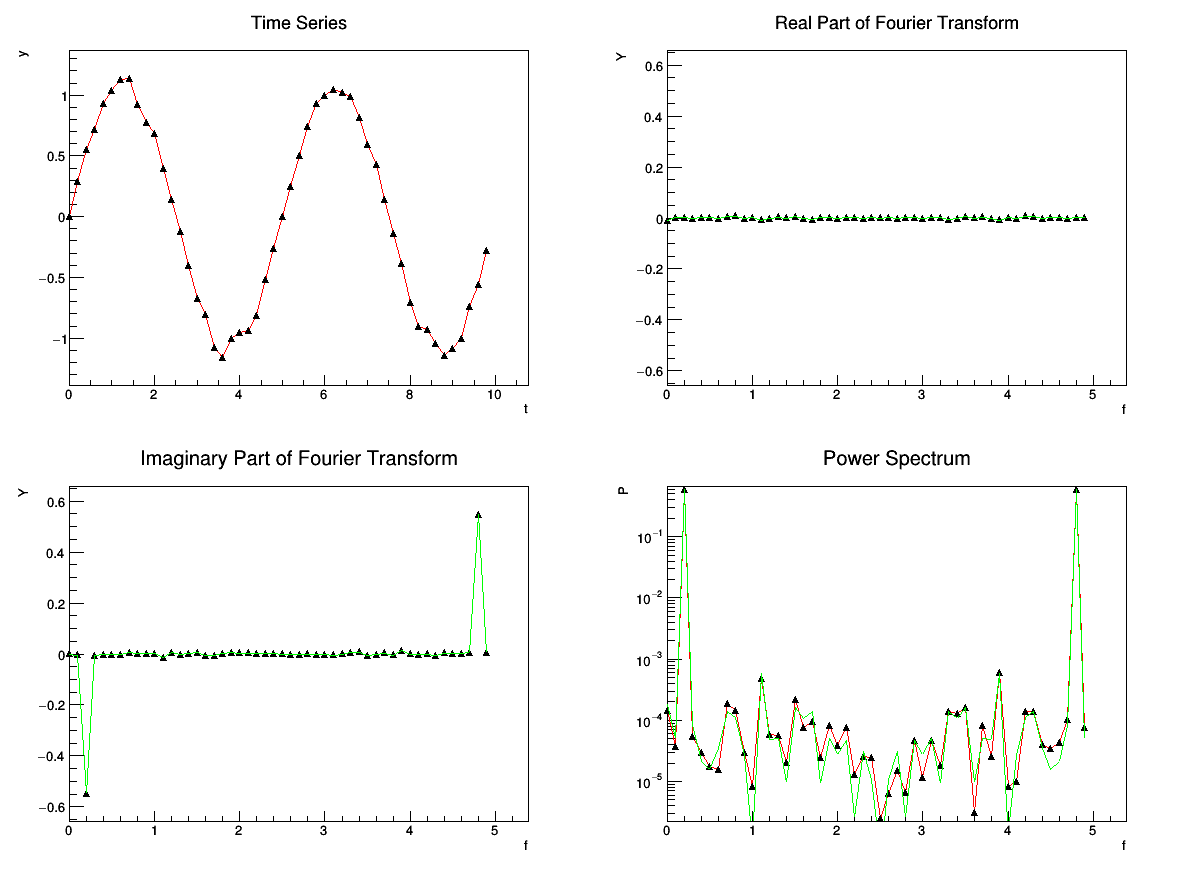

In [8]:
from ROOT import TCanvas, TFile
from ROOT import TGraph, TF1
from ROOT import gStyle, gPad

gStyle.SetOptFit(1)

c1 = TCanvas( 'c1', 'Fourier Transform', 200, 10, 1200, 900 )
c1.SetGridx()
c1.SetGridy()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderMode(-1 )
c1.GetFrame().SetBorderSize( 5 )
c1.Divide(2,2)

c1.cd(1)
gr = TGraph(N,t,y)
gr.SetMarkerStyle(22)
gr.SetLineColor(2)
gr.SetTitle("Time Series")
gr.GetXaxis().SetTitle("t")
gr.GetYaxis().SetTitle("y")
gr.Draw("APL")

c1.cd(2)
grr = TGraph(N,f,ytReal)
grr.SetMarkerStyle(22)
grr.SetLineColor(2)
grr.SetTitle("Real Part of Fourier Transform")
grr.GetXaxis().SetTitle("f")
grr.GetYaxis().SetTitle("Y")
grr.GetHistogram().SetMaximum(ymax)
grr.GetHistogram().SetMinimum(-1.0*ymax)

grrfft = TGraph(N,f,yfftReal)
grrfft.SetMarkerStyle(23)
grrfft.SetLineColor(3)
grrfft.SetTitle("Real Part of Fourier Transform")
grrfft.GetXaxis().SetTitle("f")
grrfft.GetYaxis().SetTitle("Y")
grrfft.GetHistogram().SetMaximum(ymax)
grrfft.GetHistogram().SetMaximum(-1.0*ymax)

grr.Draw("AP")
grrfft.Draw("L")

c1.cd(3)
gri = TGraph(N,f,ytImag)
grifft = TGraph(N,f,yfftImag)
gri.SetMarkerStyle(22)
grifft.SetMarkerStyle(23)
gri.SetLineColor(2)
grifft.SetLineColor(3)
gri.SetTitle("Imaginary Part of Fourier Transform")
gri.GetXaxis().SetTitle("f")
gri.GetYaxis().SetTitle("Y")
gri.GetHistogram().SetMaximum(ymax)
gri.GetHistogram().SetMinimum(-1.0*ymax)
gri.Draw("AP")
grifft.Draw("L")

c1.cd(4)
gPad.SetLogy()
grp = TGraph(N,f,power)
grpfft = TGraph(N,f,powerfft)
grp.SetMarkerStyle(22)
grpfft.SetMarkerStyle(23)
grp.SetLineColor(2)
grpfft.SetLineColor(3)
grp.SetTitle("Power Spectrum")
grp.GetXaxis().SetTitle("f")
grp.GetYaxis().SetTitle("P")
grp.Draw("APL")
grpfft.Draw("L")

c1.Draw()

In [9]:
c2 = TCanvas( 'c1', 'Fourier Transform', 200, 10, 1200, 900 )
c2.SetGridx()
c2.SetGridy()
c2.GetFrame().SetFillColor( 21 )
c2.GetFrame().SetBorderMode(-1 )
c2.GetFrame().SetBorderSize( 5 )



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


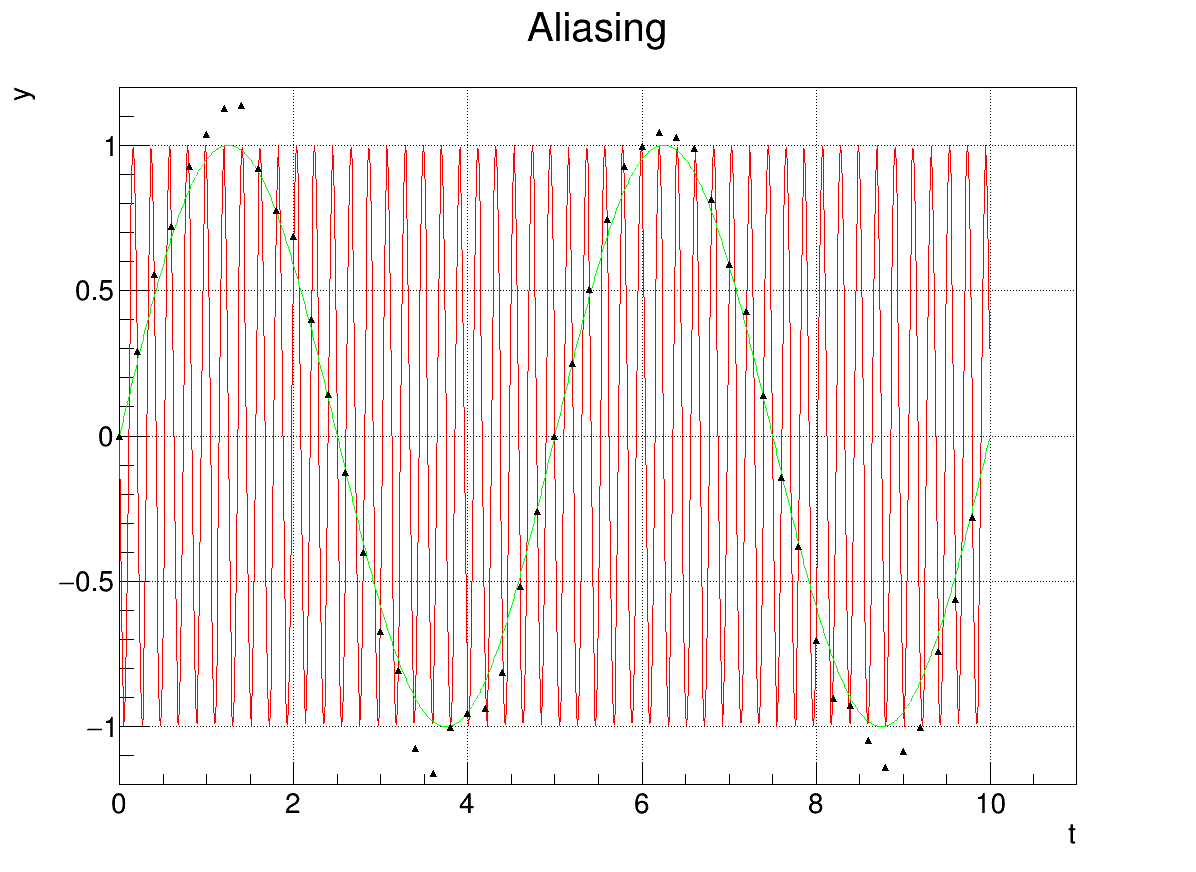

In [10]:
c2.cd()
grhigh = TGraph(1000,time,yhigh)
grlow = TGraph(1000,time,ylow)
grhigh.SetMarkerStyle(22)
grhigh.SetLineColor(2)
grhigh.SetTitle("Aliasing")
grhigh.GetXaxis().SetTitle("t")
grhigh.GetYaxis().SetTitle("y")
grlow.SetMarkerStyle(22)
grlow.SetLineColor(3)
grhigh.Draw("AL")
grlow.Draw("L")
gr.Draw("P")
c2.Draw()